In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import pickle
import json
import string
import re
import warnings
from collections import defaultdict

from random import randint, shuffle
from tqdm import tqdm
from tqdm.keras import TqdmCallback

import numpy as np
import nltk
import pandas as pd
from nltk import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout, Lambda
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

seed = 7
np.random.seed(seed)
pd.set_option('max_colwidth', -1)

In [3]:
length_class_to_label = {
    0: 'full toss',
    1: 'yorker',
    2: 'full',
    3: 'good length',
    4: 'back of a length',
    5: 'short',
}

line_class_to_label = {
    0: 'wide outside off',
    1: 'outside off',
    2: 'straight',
    3: 'down leg',
    4: 'wide down leg',
}

In [4]:
def load_data(filename):
    with open(f"{filename}.json", "rb") as f:
        data = json.load(f)
    print("Loaded data!")
    return data
        
def load_df(filename):
    with open(f"{filename}.pkl", "rb") as f:
        d = pickle.load(f)
    return d
        
def save_data(data, filename):
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(data, f)
        
def export_to_json(data):
    with open('matches.json', 'w') as json_file:
        json.dump(data, json_file)
    
i1b = lambda m : m['commentary']['innings1']['balls']
i2b = lambda m : m['commentary']['innings2']['balls']
i1o = lambda m : m['commentary']['innings1']['over_summaries']
i2o = lambda m : m['commentary']['innings2']['over_summaries']
df, players = load_df("dale_df"), load_data('player_table')

all_names = set()
ambigNames = set(['short', 'ball', 'head', 'little', 'chase', 'cutting', 'cross'])
for profile in players.values():
    name = profile['known_as'].split(' ')
    ambig = any(n.lower() in ambigNames for n in name)
    if not ambig:
        all_names.update(name)
        all_names.update([n.lower() for n in name])

Loaded data!


## Feature Engineering

In [5]:
df.head()

,desc_,hand_,length_,line_,outcome_
0,"Steyn to Jaques, full and on the legs, swinging in, Jaques lets it go past, no runs, fielded by Boucher",1,2,2,0
1,"Steyn to Jaques, good length but down leg, Jaques drives, no runs, fielded by Botha",1,3,3,0
2,"Steyn to Jaques, short of a length outside the off stump, Jaques plays no shot, no runs, fielded by Boucher",1,4,1,0
3,"(no ball) Steyn to Jaques, good length delivery just outside the off stump, Jaques lets it go past, no runs, fielded by Boucher",1,3,1,4
4,"Steyn to Jaques, fuller length outside the off stump , Jaques drives in air over cover fielder, 4 runs",1,2,1,12


In [9]:
from nltk.corpus import stopwords as st
exceptions = ['a', 'off', 'against', 'between', 'into', 'through', 'above', 'below', 'up', 'down', 'out', 'in', 'over', 'further', 'on', 'of']
stopwords = set(st.words('english'))
for w in exceptions:
    stopwords.remove(w) 

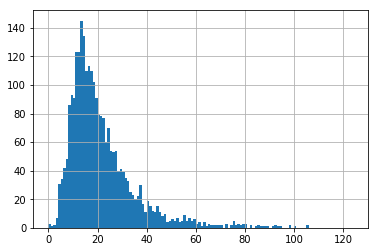

In [10]:
df['tokens'] = df['desc_'].apply(text_to_word_sequence)
lens = df['tokens'].apply(len)
lens.hist(bins=[x for x in range(125)])

In [11]:
df.head()

,desc_,hand_,length_,line_,outcome_,tokens
0,"Steyn to Jaques, full and on the legs, swinging in, Jaques lets it go past, no runs, fielded by Boucher",1,2,2,0,"[steyn, to, jaques, full, and, on, the, legs, swinging, in, jaques, lets, it, go, past, no, runs, fielded, by, boucher]"
1,"Steyn to Jaques, good length but down leg, Jaques drives, no runs, fielded by Botha",1,3,3,0,"[steyn, to, jaques, good, length, but, down, leg, jaques, drives, no, runs, fielded, by, botha]"
2,"Steyn to Jaques, short of a length outside the off stump, Jaques plays no shot, no runs, fielded by Boucher",1,4,1,0,"[steyn, to, jaques, short, of, a, length, outside, the, off, stump, jaques, plays, no, shot, no, runs, fielded, by, boucher]"
3,"(no ball) Steyn to Jaques, good length delivery just outside the off stump, Jaques lets it go past, no runs, fielded by Boucher",1,3,1,4,"[no, ball, steyn, to, jaques, good, length, delivery, just, outside, the, off, stump, jaques, lets, it, go, past, no, runs, fielded, by, boucher]"
4,"Steyn to Jaques, fuller length outside the off stump , Jaques drives in air over cover fielder, 4 runs",1,2,1,12,"[steyn, to, jaques, fuller, length, outside, the, off, stump, jaques, drives, in, air, over, cover, fielder, 4, runs]"


In [12]:
#Remove Stopwords
df['tokens_sw'] = df['tokens'].apply(lambda d: [w for w in d if w not in stopwords])

In [13]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemmas = []
    for w, tag in nltk.pos_tag(text):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        lemmas.append(lemmatizer.lemmatize(w, wntag) if wntag else w)
    return lemmas

df['lemmatized'] = df['tokens_sw'].apply(lemmatize_text)

In [14]:
sno = nltk.stem.PorterStemmer()
df['stemmed'] = df['lemmatized'].apply(lambda text: [sno.stem(w) for w in text])

In [15]:
vocab_exceptions = {'abd', "australia", "aussie", "australia's", "australian", "africa", 'african',
                    "africa's", 'au', 'b', 'bhuvi', 'c','cricinfo', "d'arcy", "dhoni's", "england",
                    "espncricinfo's", "firdose", "gould", "h", "imam", "imam's", "india", "indian",
                    "indie", "k", "lanka", "misbah","mm", "nz", "pakistan", "pakistan's", "pm", "qdk", 
                    "r", "sa", "sa's", "samuel", "sanga", "sarfraz", "sl", "sr", "sri", "steyn's",
                    "sujesh", "ul", "uae", "v", "wc", "wi", "wk", "xi", "zimbabwe", "zealand", "†de", 
                    "international", "kw", "kmh", "kph", "mr", "odi", "odis"}

def deleteLowCount(t, threshold):
    lcw = [w for w,c in t.word_counts.items() 
           if c < threshold  or w in all_names  
           or any(i.isdigit() for i in w) or w in vocab_exceptions]
    print(f"{len(lcw)} low counted, {len(t.word_counts) - len(lcw)} left")
    for w in lcw:
        del t.word_index[w]
        del t.word_docs[w]
        del t.word_counts[w]
    return t

In [39]:
col_to_tokenize = 'lemmatized'
t = Tokenizer()
t.fit_on_texts(df[col_to_tokenize])
t = deleteLowCount(t, 5)
rT = dict(map(reversed, t.word_index.items()))
df['sequence'] = t.texts_to_sequences(df[col_to_tokenize])
filtered = df['sequence'].apply(lambda x: [rT[num] for num in x])

t = Tokenizer()
t.fit_on_texts(filtered)
df['sequence'] = t.texts_to_sequences(filtered)
rT = dict(map(reversed, t.word_index.items()))
numDistinctWords = len(t.word_index) + 1

df[f'{col_to_tokenize}_common'] = df['sequence'].apply(lambda x: ' '.join([rT[num] for num in x]))
save_data(set(rT.values()), "vocab")

3768 low counted, 767 left


In [17]:
word_vectorizer = CountVectorizer(ngram_range=(1,6), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df[f'{col_to_tokenize}_common'])
frequencies = sum(sparse_matrix).toarray()[0]
freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

In [18]:
def get_feature_importances(model, analyzer, ngram_range=(1,2), lowercase=True, min_df=10, max_df=1000, sampsize=2419, category='length_'):
    tfv = TfidfVectorizer(min_df=min_df,
                          max_df=max_df,
                          strip_accents='unicode',
                          analyzer=analyzer,
                          ngram_range=ngram_range,
                          lowercase=lowercase
                         )
    df_sample = df.sample(sampsize, random_state=seed)
    X = tfv.fit_transform(df_sample[f'{col_to_tokenize}_common'])
    scaler = StandardScaler(with_mean=False)
    scaler.fit(X)
    terms = tfv.get_feature_names()
    var_imp = pd.DataFrame(index=terms)
    #multiclassif
    for cat in range(0,max(df_sample[category])+1):
        y = df_sample[category].apply(lambda x: 1 if x == cat else 0).values
        model.fit(X, y)
        var_imp[cat] =  np.sqrt(scaler.var_) * model.coef_[0]
        
    var_imp['freq'] = pd.Series(var_imp.index.map(lambda x: freq.loc[x]['frequency']), index=var_imp.index) #Attach frequency of ngram to importance
    return var_imp

model = LogisticRegression()
cat = 'line_'
var_imp16 = get_feature_importances(model, analyzer='word', ngram_range=(1,6), lowercase=True, min_df=5, category=cat)
var_imp26 = get_feature_importances(model, analyzer='word', ngram_range=(2,6), lowercase=True, min_df=5, category=cat)
# var_imp36 = get_feature_importances(model, analyzer='word', ngram_range=(3,6), lowercase=True, min_df=5, category=cat)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
var_imp26.sort_values(0, ascending=False).head(30)

,0,1,2,3,4,freq
full wide,0.215540,-0.085828,-0.103897,-0.012981,-0.003166,31
short wide,0.175410,-0.055490,-0.090724,-0.004794,-0.003230,24
wide outside off,0.148874,-0.093688,-0.043172,-0.009723,-0.002551,40
wide outside,0.148874,-0.093688,-0.043172,-0.009723,-0.002551,40
wide of,0.082354,0.003138,-0.068757,0.013261,-0.004098,66
outside off,0.081779,0.612955,-0.718938,-0.077283,-0.031056,611
leave alone,0.071463,-0.005317,-0.047471,0.003351,-0.004096,49
wide of off,0.068847,-0.021694,-0.034536,-0.004097,-0.000906,21
of off,0.062765,0.005332,-0.047591,-0.009274,-0.002135,40
wide length,0.062671,-0.020844,-0.029202,-0.002995,-0.000598,9


In [20]:
ngramsImportant = set()
numTop16 = 25
numTop26 = 25
for l in range(0, len(var_imp16.columns)-1):
    sortedByL16 = var_imp16.sort_values(l, ascending=False)
    sortedByL26 = var_imp26.sort_values(l, ascending=False)
    ngramsImportant.update(list(sortedByL16.iloc[:numTop16].index))
    ngramsImportant.update(list(sortedByL26.iloc[:numTop26].index))
print(f"{len(ngramsImportant)} important ngrams!")
ngramsImportant = list(ngramsImportant)

176 important ngrams!


In [21]:
def ngramsInText(text):
    ngramPresence = dict()
    for ngram in ngramsImportant:
        ngramSplit = ngram.split(' ')
        ngramPresence[ngram] = int(tuple(ngramSplit) in set(nltk.ngrams(text.split(' '), len(ngramSplit))))
    return pd.Series(ngramPresence)

ngramPresenceDf = df[f'{col_to_tokenize}_common'].apply(lambda text: ngramsInText(text))

In [27]:
# df.reset_index(drop=True, inplace=True)
# ngramPresenceDf.reset_index(drop=True, inplace=True)
df_train = pd.concat([df, ngramPresenceDf], axis=1)
# ngfeatures = list(ngramsImportant.keys())
# df_train[ngfeatures] = df_train[ngfeatures].div(df_train[ngfeatures].sum(axis=1), axis=0).fillna(0)
df_train.head(1)

,desc_,hand_,length_,line_,outcome_,tokens,tokens_sw,lemmatized,stemmed,sequence,...,throw,middle,on stump,off side,leg side wide,fine leg,on leg,length delivery,midwicket,wide down
0,"Steyn to Jaques, full and on the legs, swinging in, Jaques lets it go past, no runs, fielded by Boucher",1,2,2,0,"[steyn, to, jaques, full, and, on, the, legs, swinging, in, jaques, lets, it, go, past, no, runs, fielded, by, boucher]","[steyn, jaques, full, on, legs, swinging, in, jaques, lets, go, past, runs, fielded, boucher]","[steyn, jaques, full, on, leg, swing, in, jaques, let, go, past, run, field, boucher]","[steyn, jaqu, full, on, leg, swing, in, jaqu, let, go, past, run, field, boucher]","[15, 3, 10, 56, 5, 123, 21, 69, 30, 89]",...,0,0,0,0,0,0,1,0,0,0


## Model

In [28]:
X_features = list(ngramsImportant)
y_features = cat

In [29]:
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
X, X_test, y, y_test = train_test_split(df_train[X_features].values, df_train[y_features].values, stratify = df_train[y_features].values, test_size=0.1, random_state=seed)
# X, y = df_train[X_features].values, df_train[y_features].values
# pca = PCA(n_components=50)
# X = pca.fit_transform(X)
# print(np.cumsum(pca.explained_variance_ratio_))
print(X.shape)
print(y.shape)
# print(f"X shape: {X.shape}, X_test shape: {X_test.shape}\ny shape: {y.shape}, y_test.shape: {y_test.shape}")

(2349, 176)
(2349,)


# Deep Learning

In [30]:
def gsearch():
    # Definying grid parameters
    activation = ['relu']
    neurons = [25,30,15,20] #25, 35, 50, 100, 200]
    optimizer = ['SGD']
    param_grid = dict(activation = activation, neurons = neurons, optimizer = optimizer, class_weight=['balanced',class_weights])

    clf = KerasClassifier(build_fn= DL_Model, epochs=200, batch_size=20, verbose= 5)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

    model = GridSearchCV(estimator= clf, param_grid=param_grid, n_jobs=-1, cv=4, verbose=10)
    model.fit(X,y, callbacks=[es])

    print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), 
                                                       model.best_params_))
    save_data(model, "gridresults")

In [31]:
def DL_Model(activation= 'linear', neurons= 5, optimizer='Adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X.shape[1], activation= activation))
#     model.add(Dense(neurons, activation= activation))
#     model.add(Dropout(0.1))
    model.add(Dense(6 if cat=='length_' else 5, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return model

In [32]:
import warnings
warnings.filterwarnings('ignore')

neurons = 100
batch_size = 5
scores_ensemble = []
for i, (train_fold, test_fold) in enumerate(skf.split(X,y)):
    train_x, test_x = X[train_fold], X[test_fold]
    train_y, test_y = y[train_fold], y[test_fold]
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=8)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_y), np.ravel(train_y))
    class_weights = dict(enumerate(class_weights))
    clf = KerasClassifier(build_fn = DL_Model, 
                          neurons = neurons, 
                          activation='relu', 
                          class_weight=['balanced', class_weights], 
                          optimizer='Adam', epochs=20, batch_size=batch_size, verbose=1)
    
    clf.fit(train_x, train_y, validation_data=(test_x, test_y), callbacks=[es, mc, TqdmCallback(verbose=1)], verbose=0)
    best_model = load_model('best_model.h5')
    clf_preds = best_model.predict_proba(test_x)
    clf_class_preds = clf_preds.argmax(axis=1)
    report = classification_report(test_y, clf_class_preds, output_dict=True)
    conf_mat = confusion_matrix(clf_class_preds, test_y)
    acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
    scores_ensemble.append([report, acc])
    print(f"Fold {i+1} = {acc:.3f}!")

W0523 15:33:36.700469 4626542016 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.




Fold 1 = 0.819!



Fold 2 = 0.819!



Fold 3 = 0.831!



Fold 4 = 0.860!



Fold 5 = 0.872!



Fold 6 = 0.880!



Fold 7 = 0.812!



Fold 8 = 0.799!



Fold 9 = 0.824!



Fold 10 = 0.850!


In [33]:
print(f'Avg acc: {np.array([x[1] for x in scores_ensemble]).mean():>.3f}')

Avg acc: 0.837


In [34]:
def getClassPrecisions(scores):
    classReport = {}
    for lth in range(0, len(np.unique(train_y))):
        classReport[lth] = {}
        classReport[lth]['precision'] = 0
        classReport[lth]['recall'] = 0
        for report, acc in scores:
            classReport[lth]['precision'] += report[str(lth)]['precision']
            classReport[lth]['recall'] += report[str(lth)]['recall']
        classReport[lth]['precision'] /= 10
        classReport[lth]['recall'] /= 10
    return classReport

In [35]:
for cl, report in sorted(getClassPrecisions(scores_ensemble).items(), key=lambda x:x[1]['recall'], reverse=True):
    print(f"{line_class_to_label[int(cl)]:<17} | {report['precision']*100:>3.0f}% right, found {report['recall']*100:>3.0f}% of the ones available")

straight          |  85% right, found  91% of the ones available
outside off       |  82% right, found  80% of the ones available
wide outside off  |  82% right, found  75% of the ones available
down leg          |  80% right, found  53% of the ones available
wide down leg     |   0% right, found   0% of the ones available


In [47]:
def getECE(preds, y_test, plot=True, numBins=10):
    bins = [{'acc': 0, 'conf': []} for i in range(numBins)]
    for i, p in enumerate(preds):
        idx = int(max(p) * numBins)
        idx = numBins-1 if idx == numBins else idx
        if y_test[i] == p.argmax(axis=0):
            bins[idx]['acc'] += 1

        bins[idx]['conf'].append(max(p))

    for b in bins:
        if len(b['conf']):
            b['acc'] /= len(b['conf'])
            b['size'] = len(b['conf'])
            b['conf'] = np.mean(b['conf'])

    # for i, b in enumerate(bins):
    #     print(f"{i/numBins:.2f} | acc: {b['acc']:.2f} | {b['conf']:.2f}")

    x_plot, accs = [i/numBins for i in range(numBins)], [b['acc'] for b in bins]
    confs = [(b['conf'], b['size']) if b['conf'] else (0,0) for b in bins]
    ece = 0
    for acc, (conf, size) in zip(accs, confs):
        ece += (size/len(y_test)) * abs(acc - conf)

    if plot:
        plt.plot([x[0] for x in confs], accs)
        plt.plot(x_plot, x_plot)
        plt.xlabel("Predicted")
        plt.ylabel("Proportion correct")
        plt.show()
    return ece


0.7


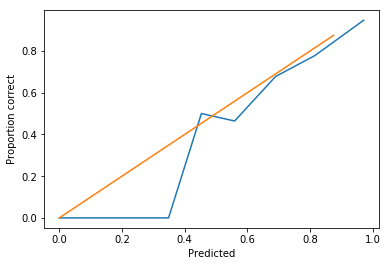

0.731578947368421


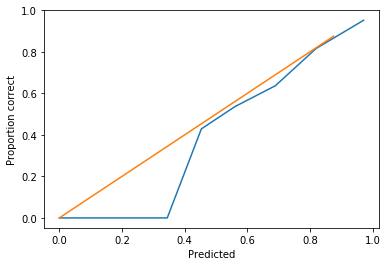

0.763157894736842


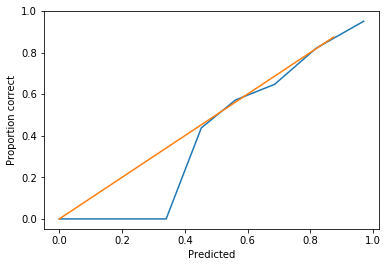

0.7947368421052632


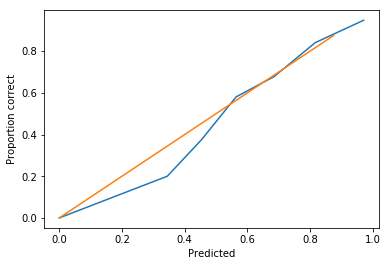

0.8263157894736842


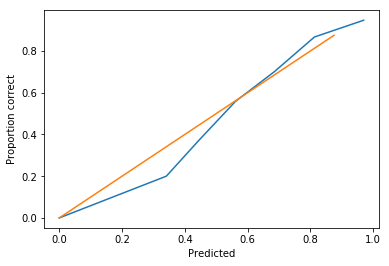

0.8578947368421053


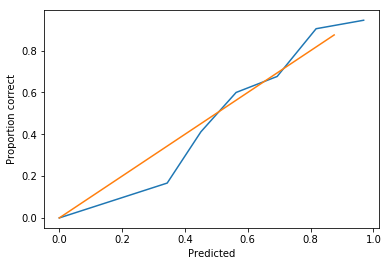

0.8894736842105263


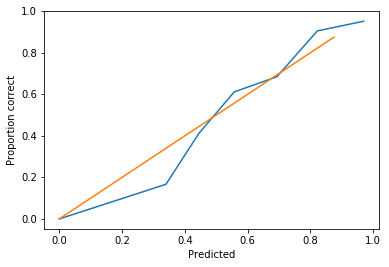

0.9210526315789473


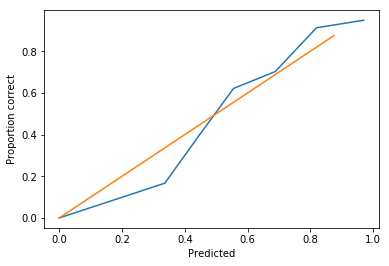

0.9526315789473685


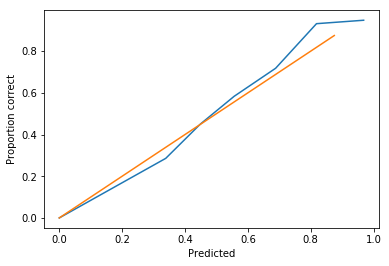

0.9842105263157894


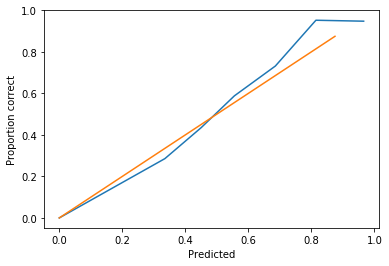

1.0157894736842106


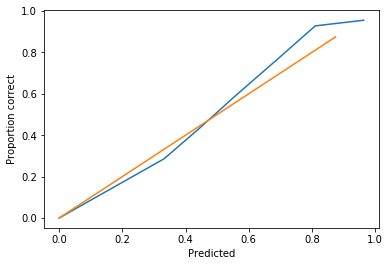

1.0473684210526315


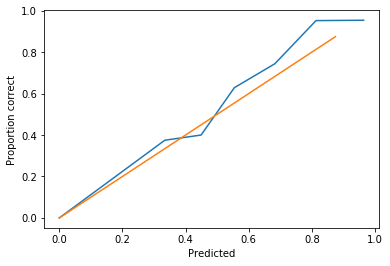

1.0789473684210527


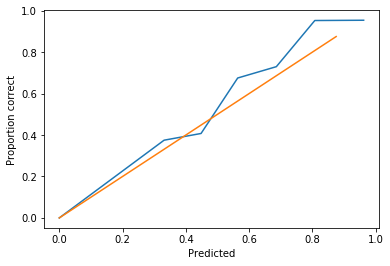

1.1105263157894738


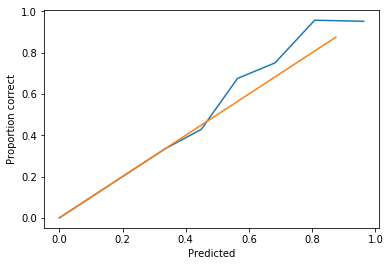

1.1421052631578947


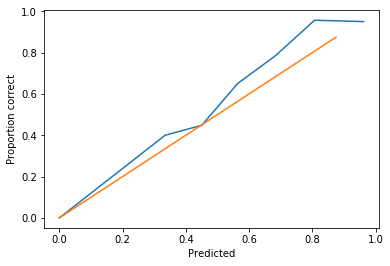

1.1736842105263159


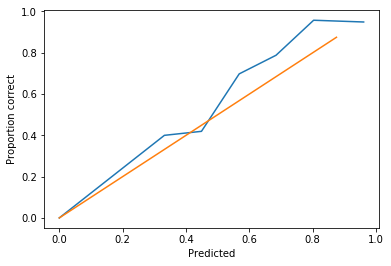

1.2052631578947368


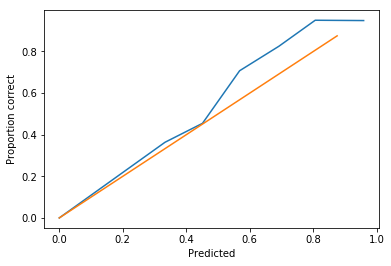

1.236842105263158


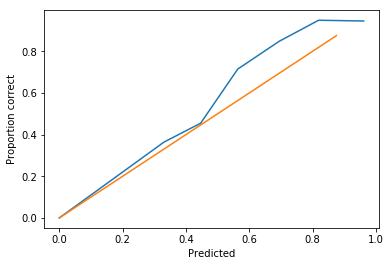

1.2684210526315791


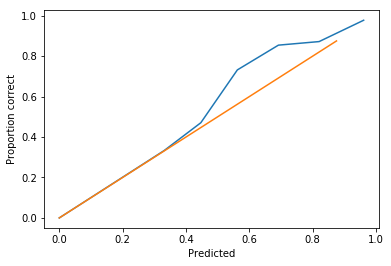

1.3


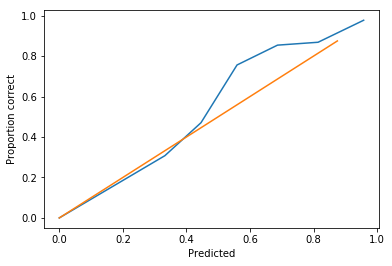

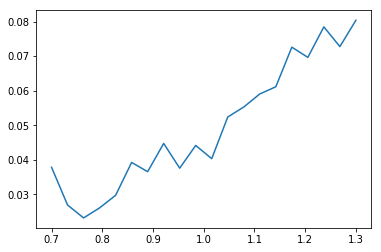

Overall accuracy: 0.805
full toss         |  62% right, found  94% of the ones available
yorker            |  86% right, found  72% of the ones available
full              |  86% right, found  87% of the ones available
good length       |  50% right, found  73% of the ones available
back of a length  |   0% right, found   0% of the ones available


In [52]:
def evaluate(neurons, epochs, batch_size, temps=[1], verbose=0, ece=False):
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y), np.ravel(y))
    class_weights = dict(enumerate(class_weights))
    
    clf = DL_Model(neurons=neurons, activation='relu', optimizer='Adam')
    clf.fit(X, y, epochs=epochs, batch_size=batch_size, 
            class_weight = class_weights, 
            callbacks=[TqdmCallback(verbose=verbose)], verbose=0)

    eces = []
    for temp in temps:
        fc=clf.layers[0]
        out=clf.layers[1]
        tempLayer = Lambda(lambda x: x / temp)
        predictors = tempLayer(fc.output)
        predictors = out(predictors)
    
        newClf = Model(input=clf.input, output=predictors)
        clf_preds = newClf.predict(X_test)
        clf_class_preds = clf_preds.argmax(axis=1)
        if ece:
            print(temp)
            eces.append(getECE(plot=True, preds = clf_preds, y_test=y_test, numBins=8))
        report = classification_report(y_test, clf_class_preds, output_dict=True)
        conf_mat = confusion_matrix(clf_class_preds, y_test)
        if verbose:
            print(conf_mat)
            
        acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
        
    if ece:
        plt.plot(temps, eces)
        plt.show()
    
    return report, acc, clf_class_preds, clf_preds

temps = np.linspace(0.7,1.3,20)
report, acc, class_preds, preds = evaluate(neurons=neurons, epochs=8, batch_size=batch_size, temps=temps, ece=True)
print(f"Overall accuracy: {acc:>.3f}")

for lth in range(len(np.unique(y))):
    print(f"{length_class_to_label[int(lth)]:<17} | {report[str(lth)]['precision']*100:>3.0f}% right, found {report[str(lth)]['recall']*100:>3.0f}% of the ones available")

In [53]:
def compileFinalModel(epochs, temperature):
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y), np.ravel(y))
    class_weights = dict(enumerate(class_weights))
    clf = DL_Model(neurons=neurons, activation='relu', optimizer='Adam')
    clf.fit(df_train[X_features].values, df_train[y_features].values, 
            epochs=epochs, batch_size=batch_size, 
            class_weight = class_weights, 
            callbacks=[TqdmCallback(verbose=1)], verbose=0)
    
    fc=clf.layers[0]
    out=clf.layers[1]
    tempLayer = Lambda(lambda x: x / temperature)
    predictors = tempLayer(fc.output)
    predictors = out(predictors)
    newClf = Model(input=clf.input, output=predictors)
    newClf.save(f'{cat}_final_{neurons}N_{batch_size}B_{epochs}.h5')

compileFinalModel(8,0.)

TypeError: compileFinalModel() missing 1 required positional argument: 'temperature'

In [38]:
save_data(ngramsImportant, "line_ngrams")